## To-Dos

### Larger Tasks
1. plot raw data to figure out wind direction error
2. see if i want to generate sync_data any differently (if not just take what Sebastien gave me)
3. rewrite car_speed functions, sampling gps_time more locally

### Smaller Tasks
* centre rolling window
* for averaged filtered data, set minimum (and perhaps visualize) number of data points in each mean
* generate numeric output - eventually write to merged data files (which i will have generated myself?)

## Overview

Original code created on Mon Jun 11 13:38:05 2018 by Sébastien in Python 2

Restructured and repurposed in June 2021 by Shiqi Xu in Python 3.7.4

*Note 1: only measurements taken before 11-2018 were uncorrected, but will run this on the Airmar uncorrected wind data as well to compare this correction with Airmar correction*

*Note 2: data from Pearson and Buttonville airports is used for comparison (downloaded in UTC), sourced from https://climate.weather.gc.ca/historical_data/search_historic_data_e.html*

To run script, ensure that the correct sync_data files are available, as well as the airport data referenced in *Note 2* above. Set paths for the sync_data, airport data, and output figures in the `Main` section of the code at the bottom. The `savefig` input parameter in the plotting functions can be toggled to determine whether figures are saved as PNG files to the specified output path or visualized in the editor.

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import os
import pandas as pd
from datetime import datetime, timedelta
from math import *
import numpy as np
from statistics import mean

from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, MultipleLocator

import pylab as pl
from scipy import stats

## Reading data

* sync_data (UTC)
* airport_data (UTC)

### Read merged GPS & wind data ("sync_data")

*Note 3: for below code, all sync_data files are stored in the same directory, with no subdirectories.*

*Note 4: The function, `convert_to_time_gps`, converts the strings in the csv datasets to timestamps which are `datetime` objects.*

In [2]:
def read_merged_gps_wind_data(day_processing, path_sync_data):

    def convert_to_time_gps(x):
        return datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")		# datetime.datetime.strptime()

    car_file = "sync_data_" + day_processing + "_Truck.csv"

    df_sync = pd.read_csv(os.path.join(path_sync_data, car_file))

    df_sync["gps_time"] = df_sync["gps_time"].apply(convert_to_time_gps)
    gps_time = df_sync["gps_time"]
    df_sync.set_index("gps_time", inplace=True)

    lat, lon = df_sync["lat"], df_sync["lon"]
    
    # check for missing wind data
    if (df_sync['ws_uncorr'].astype(str).str.lower() == 'nan').any():
        if (df_sync['ws_uncorr'].astype(str).str.lower() == 'nan').any():
            print("!! missing wind speed and direction data on " + day_processing + ", data not read for this day !!\n")
            wind_speed, wind_dir = [], []
        else:
            print("!! missing wind speed data on " + day_processing + ", data not read for this day !!\n")
            wind_speed = df_sync["ws_uncorr"]
            wind_dir = []
    else:
        if (df_sync['ws_uncorr'].astype(str).str.lower() == 'nan').any():
            print("!! missing wind direction data on " + day_processing + ", data not read for this day !!\n")
            wind_speed = []
            wind_dir = df_sync["wd_uncorr"]
        else:
            print("generating wind speed & direction . . .")
            wind_speed, wind_dir = df_sync["ws_uncorr"], df_sync["wd_uncorr"]

    return gps_time, lat, lon, wind_speed, wind_dir

### Read airport data

Pearson and Buttonville airports, sourced from https://climate.weather.gc.ca/historical_data/search_historic_data_e.html

* Pearson:    
`lat_p, lon_p = -79.63, 43.68`
* Buttonville:    
`lat_b, lon_b = -79.37, 43.86`

*Note 5:*

*The raw airport time format is `"YYYY-MM-DD HH:MM"`, and it is of `<class 'str'>`. We need to know this for the `convert_to_time_airport` function which converts the strings in the csv datasets to timestamps which are `datetime` objects.*

*Format obtained as such:*
```
test_format = df_pearson_month["Date/Time (UTC)"]
print("airport time format:\t" + test_format[0] + '\t' + type(test_format[0]))
```

In [3]:
def read_airport_data(day_processing, path_airport_data):

    def convert_to_time_airport(x):
        return datetime.strptime(x, "%Y-%m-%d %H:%M")		# datetime.datetime.strptime()

    # airport_codes = {'pearson': 6158731, 'buttonville': 6158409}
    pearson_file = os.path.join('pearson', 'en_climate_hourly_ON_6158731_%s-%s_P1H.csv' % (day_processing[5:7], day_processing[0:4]))
    buttonville_file = os.path.join('buttonville', 'en_climate_hourly_ON_6158409_%s-%s_P1H.csv' % (day_processing[5:7], day_processing[0:4]))

    df_pearson_month = pd.read_csv(os.path.join(path_airport_data, pearson_file))
    df_pearson_month.set_index("Date/Time (UTC)", inplace=True)
    # print('\n\n========== df_pearson_month ==========\n\n', df_pearson_month)

    df_buttonville_month = pd.read_csv(os.path.join(path_airport_data, buttonville_file))
    df_buttonville_month.set_index("Date/Time (UTC)", inplace=True)
    # print('\n\n========== df_buttonville_month ==========\n\n', df_buttonville_month)


    ## select time range that matches that of car data

    airport_start_hour = gps_time.iloc[0].hour			# <class 'int'>
    airport_end_hour = gps_time.iloc[-1].hour + 1		# <class 'int'>
    # print('type(airport_start_hour):', type(airport_start_hour))
    # print('type(airport_end_hour):', type(airport_end_hour))

    if airport_start_hour < 10:
        airport_start_index = day_processing + " 0" + str(airport_start_hour) + ":00"
    else:
        airport_start_index = day_processing + " " + str(airport_start_hour) + ":00"
    if airport_end_hour < 10:
        airport_end_index = day_processing + " 0" + str(airport_end_hour) + ":00"
    else:
        airport_end_index = day_processing + " " + str(airport_end_hour) + ":00"
    # print('airport_start_index:', airport_start_index)
    # print('airport_end_index:', airport_end_index)

    df_pearson = df_pearson_month.loc[airport_start_index:airport_end_index]			# index range inclusive
    # print('\n\n========== df_pearson ==========\n\n', df_pearson)

    df_buttonville = df_buttonville_month.loc[airport_start_index:airport_end_index]	# index range inclusive
    # print('\n\n========== df_buttonville ==========\n\n', df_buttonville)


    # generate lists containing airport data (time, wind speed, wind direction) that match in range with car data

    airport_time = []
    for i in range(len(df_pearson.index)):
        airport_time.append(convert_to_time_airport(list(df_pearson.index.values)[i]))
    # print('\nairport_time:\n', airport_time)

    pearson_speed = df_pearson.loc[:, "Wind Spd (km/h)"].copy() / 3.6		# km/h to m/s
    pearson_dir = df_pearson.loc[:, "Wind Dir (10s deg)"].copy() * 10		# tens of deg to deg
    # print("\n\npearson_speed:\n\n", pearson_speed)
    # print("\n\npearson_dir:\n\n", pearson_dir)

    buttonville_speed = df_buttonville.loc[:, "Wind Spd (km/h)"].copy() / 3.6
    buttonville_dir = df_buttonville.loc[:, "Wind Dir (10s deg)"].copy() * 10
    # print("\n\nbuttonville_speed:\n\n", buttonville_speed)
    # print("\n\nbuttonville_dir:\n\n", buttonville_dir)
    
    return airport_time, pearson_speed, pearson_dir, buttonville_speed, buttonville_dir

## Corrections and Averaging

### Calculate car speed & direction

Finding distance from two sets of latitude & longitude:
```
dlon = lon2 - lon1
dlat = lat2 - lat1
a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))
distance = R * c
```
~ from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

Finding bearing from two sets of latitude (φ) & longitude (λ):
```
y = math.sin(λ2-λ1) * math.cos(φ2)
x = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(λ2-λ1)
θ = math.atan2(y, x)
bearing = (θ * 180 / math.pi + 360) % 360		# in degrees
```
~ from https://www.movable-type.co.uk/scripts/latlong.html

In [4]:
def find_car_speed_and_dir(gps_time, lat, lon):
    
    # this needs fixing!!!

    R_earth = 6371000		# radius of Earth, in m

    car_speed, car_dir, car_time = [], [], []

    for i in range(1,len(lat)):

        car_time.append(gps_time[i])	# to make match wind timestamps to make correction easier
        # car_time.append( (gps_time[i]-gps_time[i-1]) / 2 )

        # convert to radians
        lat1 = radians(lat[i-1])
        lat2 = radians(lat[i])
        lon1 = radians(lon[i-1])
        lon2 = radians(lon[i])

        # Δlat and Δlon
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        # distance travelled between 2 data points, in m
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        dist = R_earth * c

        # car speed
        dtime = (gps_time[i] - gps_time[i-1]).total_seconds()
        car_speed.append( dist / dtime )

        # car heading, in degrees
        Y = sin(dlon) * cos(lat2)
        X = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
        car_dir.append((degrees(atan2(Y, X)) + 360) % 360)

    # print('len(car_dir):', len(car_dir))
   
    return car_speed, car_dir, car_time

In [5]:
# change this to use more local car speeds (get from raw data)

def find_car_speed_and_dir_pt2(car_speed, car_dir, car_time):

    # print('len(car_time):', len(car_time))
    # print('len(gps_time):', len(gps_time))
    # # car_time is 1 shorter than gps_time
    # # therefore we have 1 more wind data point than car

    ##### average adjacent car data points, tag on first and last as is (car_time, car_speed, car_dir are 1 shorter than gps_time)
    cs, cd = [], []
    for i in range(len(car_time)):
        if i == 0:
            cs.append(car_speed[i])
            cd.append(car_dir[i])
        else:
            # x and y components of [i-1] and [i] velocity vectors (can think of as regular coordinate system rotated 90 deg ccw)
            v1_x = -1 * car_speed[i-1] * cos(radians(car_dir[i-1]))
            v1_y = -1 * car_speed[i-1] * sin(radians(car_dir[i-1]))
            v2_x = -1 * car_speed[i] * cos(radians(car_dir[i]))
            v2_y = -1 * car_speed[i] * sin(radians(car_dir[i]))
            # average v1 and v2
            v_avg_x = (v1_x + v2_x) / 2
            v_avg_y = (v1_y + v2_y) / 2
            # find avg speed and dir
            cs_avg = sqrt(v_avg_x ** 2 + v_avg_y ** 2)
            cd_avg = (degrees(atan2(-v_avg_y, -v_avg_x)) + 360) % 360
            # append to lists
            cs.append(cs_avg)
            cd.append(cd_avg)
    cs.append(car_speed[-1])
    cd.append(car_dir[-1])

    # print("len(cs):", len(cs))
    # print("len(cd):", len(cd))
    # # now we have same amount of data points for wind and car
    # # use gps_time instead of car_time with cs and cd
    
    # df_car_1 = pd.DataFrame({'car_speed': car_speed, 'car_dir': car_dir}, index = car_time)
    # # print('\n\n========== df_car_1 ==========\n\n', df_car_1)

    df_car_2 = pd.DataFrame({'cs': cs, 'cd': cd}, index = gps_time)
    # print('\n\n========== df_car_2 ==========\n\n', df_car_2)

    cs = df_car_2['cs']
    cd = df_car_2['cd']
    
    return cs, cd, df_car_2

### Perform wind correction

*Note 6: can think of below coordinate system as regular coordinate system rotated 90 deg ccw (hence factor of -1)*

REWRITE using numpy array operations instead of for loop!

In [6]:
def wind_correction(cs, cd, wind_speed, wind_dir, gps_time):

    # x and y components of wind and car velocity vectors
    W_x = -1 * wind_speed * np.cos( np.radians( wind_dir ) )
    W_y = -1 * wind_speed * np.sin( np.radians( wind_dir ) )

    # x and y components of corrected wind velocity vectors
    C_x = -1 * cs * np.cos( np.radians( cd ) )
    C_y = -1 * cs * np.sin( np.radians( cd ) )

    # x and y components of corrected wind velocity vectors
    wind_vector_corr_x = W_x + C_x
    wind_vector_corr_y = W_y + C_y

    # corrected wind speed & direction
    wind_speed_corr = np.sqrt( wind_vector_corr_x ** 2 + wind_vector_corr_y ** 2 )
    wind_dir_corr = ( np.degrees( np.arctan2( -1 * wind_vector_corr_y, -1 * wind_vector_corr_x ) ) + 360 ) % 360

    df_wind_corr = pd.DataFrame({'wind_speed_corr': wind_speed_corr, 'wind_dir_corr': wind_dir_corr, 'wind_vector_corr_x': wind_vector_corr_x, 'wind_vector_corr_y': wind_vector_corr_y}, index = gps_time)
    # print('\n\n========== df_wind_corr ==========\n', df_wind_corr)

    return wind_speed_corr, wind_dir_corr, wind_vector_corr_x, wind_vector_corr_y, df_wind_corr

### Filter for measurements while car is stationary

No wind correction needed for these data points.

In [7]:
def stationary_car_filter(cs, wind_speed, wind_dir, gps_time):
    
    wind_speed_stop, wind_dir_stop, time_stop = [], [], []
    
    for i in range(len(gps_time)):
        if cs[i] == 0:
            time_stop.append(gps_time[i])
            wind_speed_stop.append(wind_speed[i])
            wind_dir_stop.append(wind_dir[i])
    
    # print('len(wind_speed_stop):', len(wind_speed_stop))
    # print('len(wind_dir_stop):', len(wind_dir_stop))
    
    df_wind_stop = pd.DataFrame({'wind_speed_stop': wind_speed_stop, 'wind_dir_stop': wind_dir_stop}, index = time_stop)
    # print('\n\n========== df_wind_stop ==========\n', df_wind_stop)

    # x and y components generated for later averaging
    df_wind_stop['wind_vector_stop_x'] = -1 * df_wind_stop['wind_speed_stop'] * np.cos( np.radians( df_wind_stop['wind_dir_stop'] ) )
    df_wind_stop['wind_vector_stop_y'] = -1 * df_wind_stop['wind_speed_stop'] * np.sin( np.radians( df_wind_stop['wind_dir_stop'] ) )
    
    return wind_speed_stop, wind_dir_stop, time_stop, df_wind_stop

### Moving averages of corrected wind speed and direction

*** was unable to centre the rolling window for some reason - got the following error message: `center is not implemented for datetimelike and offset based windows`

In [8]:
def rolling_avg_winds_corr(df_wind_corr, window_size):

    df_wind_corr['wind_vector_corr_rolling_avg_x'] = df_wind_corr['wind_vector_corr_x'].rolling(window_size).mean()
    df_wind_corr['wind_vector_corr_rolling_avg_y'] = df_wind_corr['wind_vector_corr_y'].rolling(window_size).mean()
    # df_wind_corr['wind_vector_corr_rolling_avg_x'] = df_wind_corr['wind_vector_corr_x'].rolling(window_size, center=True).mean()
    # df_wind_corr['wind_vector_corr_rolling_avg_y'] = df_wind_corr['wind_vector_corr_y'].rolling(window_size, center=True).mean()

    # print("\ndf_wind_corr['wind_vector_corr_rolling_avg_x']:\n", df_wind_corr['wind_vector_corr_rolling_avg_x'])
    # print("\ndf_wind_corr['wind_vector_corr_rolling_avg_y']:\n", df_wind_corr['wind_vector_corr_rolling_avg_y'])

    df_wind_corr['wind_speed_corr_rolling_avg'] = np.sqrt( df_wind_corr['wind_vector_corr_rolling_avg_x'] ** 2 + df_wind_corr['wind_vector_corr_rolling_avg_y'] ** 2 )
    df_wind_corr['wind_dir_corr_rolling_avg'] = ( np.degrees( np.arctan2( -1 * df_wind_corr['wind_vector_corr_rolling_avg_y'], -1 * df_wind_corr['wind_vector_corr_rolling_avg_x'] ) ) + 360 ) % 360

    wind_speed_corr_rolling_avg = df_wind_corr['wind_speed_corr_rolling_avg']
    wind_dir_corr_rolling_avg = df_wind_corr['wind_dir_corr_rolling_avg']

    time_rolling_avg = df_wind_corr[df_wind_corr['wind_speed_corr_rolling_avg'].notna()].index.tolist()

#     print('\nlen(df_wind_corr.index):', len(df_wind_corr.index))
#     print('\nlen(wind_speed_corr_rolling_avg):\n', len(wind_speed_corr_rolling_avg))
#     print('\nlen(wind_dir_corr_rolling_avg):\n', len(wind_dir_corr_rolling_avg))
#     print('\nlen(time_rolling_avg):\n', len(time_rolling_avg))

    return wind_speed_corr_rolling_avg, wind_dir_corr_rolling_avg, time_rolling_avg

### Binned hourly averages of corrected wind speed and direction

In [9]:
def binned_hourly_avg_winds_corr(df_wind_corr, gps_time, day_processing):

    hours = [gps_time[i].hour for i in range(len(gps_time))]
    
    hours_unique = list(dict.fromkeys(hours))
    del hours_unique[0]			# discard endpoints
    del hours_unique[-1]		# discard endpoints
    # print(hours_unique)

    wind_speed_corr_hourly_avg = []
    wind_dir_corr_hourly_avg = []

    for i in range(len(hours_unique)):
        hour_wind_vector_corr_x = []
        hour_wind_vector_corr_y = []
        for j in range(len(gps_time)):
            if gps_time[j].hour == hours_unique[i]:
                hour_wind_vector_corr_x.append(df_wind_corr.loc[gps_time[j], 'wind_vector_corr_x'])
                hour_wind_vector_corr_y.append(df_wind_corr.loc[gps_time[j], 'wind_vector_corr_y'])
        wind_vector_corr_hourly_avg_x = mean(hour_wind_vector_corr_x)
        wind_vector_corr_hourly_avg_y = mean(hour_wind_vector_corr_y)
        
        wind_speed_corr_hourly_avg.append( sqrt(  wind_vector_corr_hourly_avg_x ** 2 + wind_vector_corr_hourly_avg_y ** 2 ) )
        wind_dir_corr_hourly_avg.append( ( degrees( atan2( -1 * wind_vector_corr_hourly_avg_y, -1 * wind_vector_corr_hourly_avg_x ) ) + 360 ) % 360 )

    # print('\nlen(wind_speed_corr_hourly_avg):\n', len(wind_speed_corr_hourly_avg))
    # print('\nlen(wind_dir_corr_hourly_avg):\n', len(wind_dir_corr_hourly_avg))
    # print('\nlen(hours_unique):\n', len(hours_unique))

    # convert hours_unique into datetime objects, centering each data point in the interval at half past the hour
    time_hourly_avg = [datetime(int(day_processing[:4]), int(day_processing[5:7]), int(day_processing[8:]), hours_unique[i], 30, 0) for i in range(len(hours_unique))]

    df_wind_corr_hourly_avg = pd.DataFrame({'wind_speed_corr_hourly_avg': wind_speed_corr_hourly_avg, 'wind_dir_corr_hourly_avg': wind_dir_corr_hourly_avg}, index = time_hourly_avg)
    # print('\n\n========== df_wind_corr_hourly_avg ==========\n', df_wind_corr_hourly_avg)

    return wind_speed_corr_hourly_avg, wind_dir_corr_hourly_avg, time_hourly_avg, df_wind_corr_hourly_avg

### Find threshold for averaging filtered winds

Want a minimum of 2/3 of non-filtered data points in an interval in order to generate a filtered average.

In [10]:
def find_threshold(df_wind_corr, window_size_stop):

    list_data_count = []

    window_duration = np.timedelta64(int(window_size_stop[:-1]), window_size_stop[-1])

    for i in range(len(df_wind_corr.index)):
        if df_wind_corr.index.values[i] + window_duration > df_wind_corr.index.values[-1]:
            break
        j = i + 1
        data_count_in_interval = 0		# to prevent overcount from last iteration of while loop
        while df_wind_corr.index.values[j] < df_wind_corr.index.values[i] + window_duration:
            data_count_in_interval += 1
            j += 1
        list_data_count.append(data_count_in_interval)

    threshold = round( 2/3 * mean(list_data_count) )
    
    print('\nthreshold:', threshold)

    return threshold

### Moving averages of filtered wind speed and direction

In [11]:
def rolling_avg_winds_stop(df_wind_stop, window_size, threshold):

    df_wind_stop['wind_vector_stop_rolling_avg_x'] = df_wind_stop['wind_vector_stop_x'].rolling(window_size, min_periods=threshold).mean()
    df_wind_stop['wind_vector_stop_rolling_avg_y'] = df_wind_stop['wind_vector_stop_y'].rolling(window_size, min_periods=threshold).mean()
    # df_wind_stop['wind_vector_stop_rolling_avg_x'] = df_wind_stop['wind_vector_stop_x'].rolling(window_size, center=True).mean()
    # df_wind_stop['wind_vector_stop_rolling_avg_y'] = df_wind_stop['wind_vector_stop_y'].rolling(window_size, center=True).mean()

#     print("\ndf_wind_stop['wind_vector_stop_rolling_avg_x']:\n", df_wind_stop['wind_vector_stop_rolling_avg_x'])
#     print("\ndf_wind_stop['wind_vector_stop_rolling_avg_y']:\n", df_wind_stop['wind_vector_stop_rolling_avg_y'])

    print("\nlen(df_wind_stop['wind_vector_stop_rolling_avg_x']):\n", len(df_wind_stop['wind_vector_stop_rolling_avg_x']))
    print("\nlen(df_wind_stop['wind_vector_stop_rolling_avg_y']):\n", len(df_wind_stop['wind_vector_stop_rolling_avg_y']))

    df_wind_stop['wind_speed_stop_rolling_avg'] = np.sqrt( df_wind_stop['wind_vector_stop_rolling_avg_x'] ** 2 + df_wind_stop['wind_vector_stop_rolling_avg_y'] ** 2 )
    df_wind_stop['wind_dir_stop_rolling_avg'] = ( np.degrees( np.arctan2( -1 * df_wind_stop['wind_vector_stop_rolling_avg_y'], -1 * df_wind_stop['wind_vector_stop_rolling_avg_x'] ) ) + 360 ) % 360

#     print("\ndf_wind_stop['wind_speed_stop_rolling_avg']:\n", df_wind_stop['wind_speed_stop_rolling_avg'])
#     print("\ndf_wind_stop['wind_dir_stop_rolling_avg']:\n", df_wind_stop['wind_dir_stop_rolling_avg'])

    wind_speed_stop_rolling_avg = df_wind_stop['wind_speed_stop_rolling_avg'].dropna()
    wind_dir_stop_rolling_avg = df_wind_stop['wind_dir_stop_rolling_avg'].dropna()

    time_stop_rolling_avg = df_wind_stop[df_wind_stop['wind_speed_stop_rolling_avg'].notna()].index.tolist()
#     time_stop_rolling_avg = df_wind_stop['wind_speed_stop_rolling_avg'].index.tolist()

    print('\nlen(wind_speed_stop_rolling_avg):\n', len(wind_speed_stop_rolling_avg))
    print('\nlen(wind_dir_stop_rolling_avg):\n', len(wind_dir_stop_rolling_avg))
    print('\nlen(time_stop_rolling_avg):\n', len(time_stop_rolling_avg))

    return wind_speed_stop_rolling_avg, wind_dir_stop_rolling_avg, time_stop_rolling_avg

### Binned hourly averages of filtered wind speed and direction

need to hard-code threshold

In [12]:
def binned_hourly_avg_winds_stop(df_wind_stop, time_stop, threshold, day_processing):

    hours = [time_stop[i].hour for i in range(len(time_stop))]
    
    hours_unique = list(dict.fromkeys(hours))
    del hours_unique[0]			# discard endpoints
    del hours_unique[-1]		# discard endpoints
    # print(hours_unique)

    wind_speed_stop_hourly_avg = []
    wind_dir_stop_hourly_avg = []
    time_stop_hourly_avg = []

    for i in range(len(hours_unique)):
        hour_wind_vector_stop_x = []
        hour_wind_vector_stop_y = []
        for j in range(len(time_stop)):
            if time_stop[j].hour == hours_unique[i]:
                hour_wind_vector_stop_x.append(df_wind_stop.loc[time_stop[j], 'wind_vector_stop_x'])
                hour_wind_vector_stop_y.append(df_wind_stop.loc[time_stop[j], 'wind_vector_stop_y'])
        if len(hour_wind_vector_stop_x) >= threshold:
            wind_vector_stop_hourly_avg_x = mean(hour_wind_vector_stop_x)
            wind_vector_stop_hourly_avg_y = mean(hour_wind_vector_stop_y)

            wind_speed_stop_hourly_avg.append( sqrt(  wind_vector_stop_hourly_avg_x ** 2 + wind_vector_stop_hourly_avg_y ** 2 ) )
            wind_dir_stop_hourly_avg.append( ( degrees( atan2( -1 * wind_vector_stop_hourly_avg_y, -1 * wind_vector_stop_hourly_avg_x ) ) + 360 ) % 360 )

            # convert hours_unique into datetime objects, centering each data point in the interval at half past the hour
            time_stop_hourly_avg.append(datetime(int(day_processing[:4]), int(day_processing[5:7]), int(day_processing[8:]), hours_unique[i], 30, 0))

    # print('\nlen(wind_speed_stop_hourly_avg):\n', len(wind_speed_stop_hourly_avg))
    # print('\nlen(wind_dir_stop_hourly_avg):\n', len(wind_dir_stop_hourly_avg))
    # print('\nlen(hours_unique):\n', len(hours_unique))

    df_wind_stop_hourly_avg = pd.DataFrame({'wind_speed_stop_hourly_avg': wind_speed_stop_hourly_avg, 'wind_dir_stop_hourly_avg': wind_dir_stop_hourly_avg}, index = time_stop_hourly_avg)
    # print('\n\n========== df_wind_stop_hourly_avg ==========\n', df_wind_stop_hourly_avg)

    return wind_speed_stop_hourly_avg, wind_dir_stop_hourly_avg, time_stop_hourly_avg, df_wind_stop_hourly_avg

## Visualizations

### Organize output figures by date

Create folders for each date.

In [13]:
def create_output_fig_folders(day_processing, output_figures_path):

    try: # create folder
        os.makedirs(os.path.join(output_figures_path, day_processing))
    except OSError:
        pass

### Generate windroses for airport data

In [14]:
def windrose_airports(pearson_speed, pearson_dir, buttonville_speed, buttonville_dir, day_processing,
                      output_figures_path, savefig=False):

    pearson_ax = WindroseAxes.from_ax()
    pearson_ax.bar(pearson_dir, pearson_speed, opening=0.8, edgecolor='white')
    pearson_ax.set_xticklabels(['90°','45°','0°','315°','270°','225°','180°','135°'])
    pearson_ax.set_legend()
    
    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "windrose_pearson_" + day_processing + ".png"))
        plt.close()

    buttonville_ax = WindroseAxes.from_ax()
    buttonville_ax.bar(buttonville_dir, buttonville_speed, opening=0.8, edgecolor='white')
    buttonville_ax.set_xticklabels(['90°','45°','0°','315°','270°','225°','180°','135°'])
    buttonville_ax.set_legend()

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "windrose_buttonville_" + day_processing + ".png"))
        plt.close()

### Generate windrose for corrected winds

In [15]:
def windrose_corrected_winds(wind_dir_corr, wind_speed_corr, day_processing,
                             output_figures_path, savefig=False):
    
    stop_ax = WindroseAxes.from_ax()
    stop_ax.bar(wind_dir_corr, wind_speed_corr, opening=0.8, edgecolor='white')
    stop_ax.set_xticklabels(['90°','45°','0°','315°','270°','225°','180°','135°'])
    stop_ax.set_legend()
    
    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "windrose_corrected_winds_" + day_processing + ".png"))
        plt.close()

### Generate windrose for stationary-car winds

In [16]:
def windrose_stationary_car(wind_dir_stop, wind_speed_stop, day_processing,
                            output_figures_path, savefig=False):
    
    stop_ax = WindroseAxes.from_ax()
    stop_ax.bar(wind_dir_stop, wind_speed_stop, opening=0.8, edgecolor='white')
    stop_ax.set_xticklabels(['90°','45°','0°','315°','270°','225°','180°','135°'])
    stop_ax.set_legend()
    
    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "windrose_car_stopped_" + day_processing + ".png"))
        plt.close()

### Plot speed vs time of airport and corrected car-measured winds

In [17]:
def plot_corrected_speed_vs_time(gps_time, wind_speed, wind_speed_corr,
                                 time_rolling_avg, wind_speed_corr_rolling_avg, window_size,
                                 time_hourly_avg, wind_speed_corr_hourly_avg,
                                 airport_time, pearson_speed, buttonville_speed, day_processing,
                                 output_figures_path, savefig=False):

    fig_corr_speed_time = plt.figure(figsize=(10,5))

    gps_time_ax = md.date2num(gps_time)
    plt.plot_date(gps_time_ax, wind_speed, 'x', label='measured wind', color='cornflowerblue', markersize=3)
    # plt.plot_date(gps_time_ax, cs, 'o', label='car', color='yellow', markersize=3)
    plt.plot_date(gps_time_ax, wind_speed_corr, label='corrected wind', color='darkorange', markersize=3)
    
    rolling_avg_time_ax = md.date2num(time_rolling_avg)
    plt.plot_date(rolling_avg_time_ax, wind_speed_corr_rolling_avg, label='rolling-averaged corrected wind (' + window_size + ' window)', color='gold', markersize=3)

    hourly_avg_time_ax = md.date2num(time_hourly_avg)
    plt.plot_date(hourly_avg_time_ax, wind_speed_corr_hourly_avg, label='hourly-averaged corrected wind', color='darkorchid', marker='*', markersize=8)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, pearson_speed, label='Pearson airport wind', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, buttonville_speed, label='Buttonville airport wind', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Speeds, Corrected for Car Motion, vs Airport Wind Speeds on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Wind Speed (m/s)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_speed_corrected_" + day_processing + ".png"))
        plt.close()

### Plot speed vs time of airport and filtered car-measured winds

In [18]:
def plot_filtered_speed_vs_time(time_stop, wind_speed_stop, time_stop_rolling_avg, wind_speed_stop_rolling_avg, window_size, time_stop_hourly_avg, wind_speed_stop_hourly_avg, airport_time, pearson_speed, buttonville_speed, day_processing, output_figures_path, savefig=False):

    fig_speed_stop_times = plt.figure(figsize=(10,5))

    time_stop_ax = md.date2num(time_stop)
    plt.plot_date(time_stop_ax, wind_speed_stop, label='filtered wind, stationary-car only', color='cornflowerblue', markersize=3)

    rolling_avg_time_stop_ax = md.date2num(time_stop_rolling_avg)
    plt.plot_date(rolling_avg_time_stop_ax, wind_speed_stop_rolling_avg, label='rolling-averaged filtered wind (' + window_size + ' window)', color='gold', markersize=3)

    hourly_avg_time_ax = md.date2num(time_stop_hourly_avg)
    plt.plot_date(hourly_avg_time_ax, wind_speed_stop_hourly_avg, label='hourly-averaged filtered wind', color='darkorchid', marker='*', markersize=8)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, pearson_speed, label='Pearson airport', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, buttonville_speed, label='Buttonville airport', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Speeds, Filtered for Stationary Car, vs Airport Wind Speeds on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Wind Speed (m/s)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    
    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_speed_over_time_stopped_" + day_processing + ".png"))
        plt.close()

### Plot corrected wind speed vs car speed to check for correlation

We do not want a correlation.

In [19]:
def plot_check_for_correlation(cs, wind_speed_corr, day_processing, output_figures_path, savefig=False):

    fig_correlation = plt.figure()

    plt.plot(cs, wind_speed_corr, '.', markersize=3)
    plt.xlabel('Car Speed (m/s)')
    plt.ylabel('Corrected Wind Speed (m/s)')
    plt.title('Car Motion-Corrected Wind Speed vs Car Speed on ' + day_processing)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_speed_corr_vs_car_speed_" + day_processing + ".png"))
        plt.close()

### Plot direction vs time of airport and corrected car-measured winds

In [20]:
def plot_corrected_dir_vs_time(gps_time, wind_dir, wind_dir_corr, airport_time, pearson_dir, buttonville_dir, day_processing, output_figures_path, savefig=False):

    fig_corr_dir_time = plt.figure(figsize=(10,5))

    gps_time_ax = md.date2num(gps_time)
    plt.plot_date(gps_time_ax, wind_dir, 'x', label='measured wind', color='cornflowerblue', markersize=3)
    # plt.plot_date(gps_time_ax, cs, 'o', label='car', markersize=3)
    plt.plot_date(gps_time_ax, wind_dir_corr, label='corrected wind', color='darkorange', markersize=3)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, pearson_dir, label='Pearson airport wind', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, buttonville_dir, label='Buttonville airport wind', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Direction, Corrected for Car Motion, vs Airport Wind Direction on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Wind Direction, Clockwise from North (°)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.yaxis.set_major_locator(MultipleLocator(60))
    ax.yaxis.set_minor_locator(MultipleLocator(30))

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_direction_corrected_" + day_processing + ".png"))
        plt.close()

### Plot sine of direction vs time of airport and corrected car-measured winds

In [21]:
def plot_sine_corrected_dir_vs_time(gps_time, wind_dir, wind_dir_corr, airport_time, pearson_dir, buttonville_dir, day_processing, output_figures_path, savefig=False):

    fig_sine_corr_dir_time = plt.figure(figsize=(10,5))

    sin_wind_dir = [sin(radians(wind_dir[i])) for i in range(len(wind_dir))]
    sin_wind_dir_corr = [sin(radians(wind_dir_corr[i])) for i in range(len(wind_dir_corr))]
    sin_pearson_dir = [sin(radians(pearson_dir[i])) for i in range(len(pearson_dir))]
    sin_buttonville_dir = [sin(radians(buttonville_dir[i])) for i in range(len(buttonville_dir))]

    gps_time_ax = md.date2num(gps_time)
    plt.plot_date(gps_time_ax, sin_wind_dir, 'x', label='measured wind', color='cornflowerblue', markersize=3)
    # plt.plot_date(gps_time_ax, cs, 'o', label='car', markersize=3)
    plt.plot_date(gps_time_ax, sin_wind_dir_corr, label='corrected wind', color='darkorange', markersize=3)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, sin_pearson_dir, label='Pearson airport wind', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, sin_buttonville_dir, label='Buttonville airport wind', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Direction, Corrected for Car Motion, vs Airport Wind Direction on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Sine of Wind Direction (Clockwise from North)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_direction_corrected_sine_" + day_processing + ".png"))
        plt.close()

### Plot direction vs time of airport and filtered car-measured winds

In [22]:
def plot_filtered_dir_vs_time(time_stop, wind_dir_stop, airport_time, pearson_dir, buttonville_dir, day_processing, output_figures_path, savefig=False):

    fig_dir_stop_times = plt.figure(figsize=(10,5))

    time_stop_ax = md.date2num(time_stop)
    plt.plot_date(time_stop_ax, wind_dir_stop, label='car weather station, corrected, stationary-car only', color='cornflowerblue', markersize=3)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, pearson_dir, label='Pearson airport', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, buttonville_dir, label='Buttonville airport', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Direction, Filtered for Stationary Car, vs Airport Wind Direction on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Wind Direction, Clockwise from North (°)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.yaxis.set_major_locator(MultipleLocator(60))
    ax.yaxis.set_minor_locator(MultipleLocator(30))
    
    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_direction_over_time_stopped_" + day_processing + ".png"))
        plt.close()

### Plot sine of direction vs time of airport and filtered car-measured winds

In [23]:
def plot_sine_filtered_dir_vs_time(time_stop, wind_dir_stop, airport_time, pearson_dir, buttonville_dir, day_processing, output_figures_path, savefig=False):

    fig_sine_dir_stop_times = plt.figure(figsize=(10,5))

    sin_wind_dir_stop = [sin(radians(wind_dir_stop[i])) for i in range(len(wind_dir_stop))]
    sin_pearson_dir = [sin(radians(pearson_dir[i])) for i in range(len(pearson_dir))]
    sin_buttonville_dir = [sin(radians(buttonville_dir[i])) for i in range(len(buttonville_dir))]

    time_stop_ax = md.date2num(time_stop)
    plt.plot_date(time_stop_ax, sin_wind_dir_stop, label='car weather station, corrected, stationary-car only', color='cornflowerblue', markersize=3)

    airport_time_ax = md.date2num(airport_time)
    plt.plot_date(airport_time_ax, sin_pearson_dir, label='Pearson airport', color='forestgreen', markersize=7)
    plt.plot_date(airport_time_ax, sin_buttonville_dir, label='Buttonville airport', color='firebrick', markersize=7)

    plt.title('Car-Measured Wind Direction, Filtered for Stationary Car, vs Airport Wind Direction on ' + day_processing)
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Sine of Wind Direction (Clockwise from North)")
    plt.legend(fontsize='x-small')
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    if savefig == True:
        print("saving figure to output path . . .")
        plt.savefig(os.path.join(output_figures_path, day_processing, "wind_direction_over_time_stopped_sine_" + day_processing + ".png"))
        plt.close()

## Main
Apply corrections / filter data and generate plots

*Note 7: wind data prior to 2018-10-13 (inclusive) is not corrected.*

### Set paths for input data and output figures

In [24]:
path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_sync_data = os.path.join(path_root, "data", "mobile_data_2018-2020")
path_airport_data = os.path.join(path_root, "data", "airport_data")
output_figures_path = os.path.join(path_root, "outputs", "fig", "winds_filter_stationary_car")

### Get dates

In [25]:
filenames = os.listdir(path_sync_data)

dates_all = []
dates_car = []
dates_bike = []

for filename in filenames:
    if (len(filename) > 4) and (filename[-4:] == '.csv') and (filename[:10] == 'sync_data_'):
        dates_all.append(filename[10:-4])
        if (len(filename) > 21) and (filename[-10:-4] == '_Truck'):
            dates_car.append(filename[10:-10])
        else:
            dates_bike.append(filename[10:-4])

# print("\ndates_all:\n", dates_all)
print("\ndates_car:\n", dates_car)
# print("\ndates_bike:\n", dates_bike)

dates_car_uncorr = []

for date in dates_car:
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:])
    if (year < 2018) or (year == 2018 and month < 10) or (year == 2018 and month == 10 and day <= 13):
        dates_car_uncorr.append(date)

print("\ndates_car_uncorr (wind data uncorrected):\n", dates_car_uncorr)


dates_car:
 ['2018-08-16', '2018-08-17', '2018-08-28', '2018-08-30', '2018-09-27', '2018-10-03', '2018-10-06', '2018-10-13', '2018-11-20', '2018-11-22', '2018-11-28', '2018-11-29', '2018-12-04', '2018-12-07', '2019-04-04', '2019-04-09', '2019-04-15', '2019-04-25', '2019-06-05', '2019-06-06', '2019-06-21', '2019-09-27', '2019-10-04', '2019-10-17', '2019-12-04', '2019-12-12', '2020-01-08', '2020-01-09', '2020-01-21', '2020-01-30', '2020-02-05', '2020-02-19', '2020-03-05']

dates_car_uncorr (wind data uncorrected):
 ['2018-08-16', '2018-08-17', '2018-08-28', '2018-08-30', '2018-09-27', '2018-10-03', '2018-10-06', '2018-10-13']


### Set window sizes for rolling averages

*Note 9: the filtered data is much sparser, with 10-15 minute stops happening here and there, not every hour.*

*Note 10: use 's' or 'h' as the unit for these to avoid ambiguity!*

In [26]:
window_size_corr = '1h'
window_size_stop = '300s'

### Run corrections and create visualizations!

generating wind speed & direction . . .

threshold: 98

len(df_wind_stop['wind_vector_stop_rolling_avg_x']):
 550

len(df_wind_stop['wind_vector_stop_rolling_avg_y']):
 550

len(wind_speed_stop_rolling_avg):
 5

len(wind_dir_stop_rolling_avg):
 5

len(time_stop_rolling_avg):
 5
~~~ finished processing 2018-08-16 ~~~



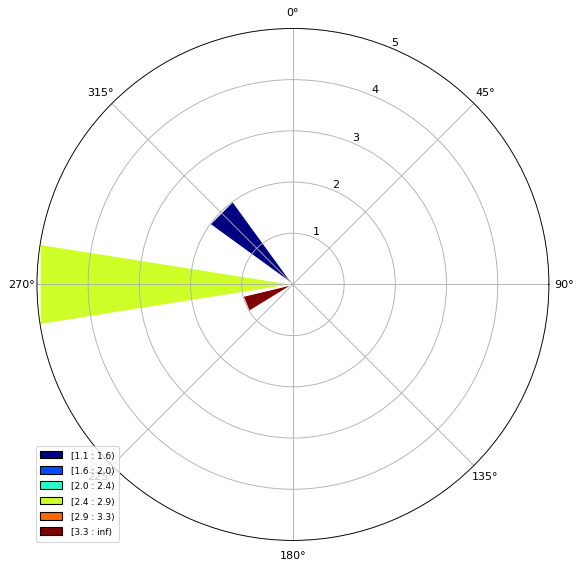

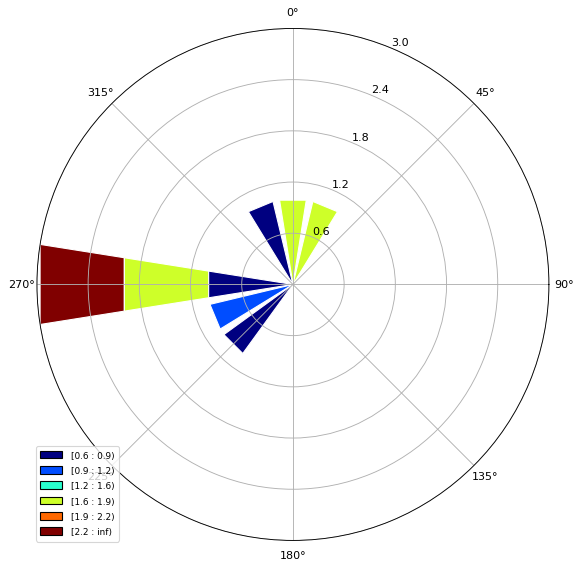

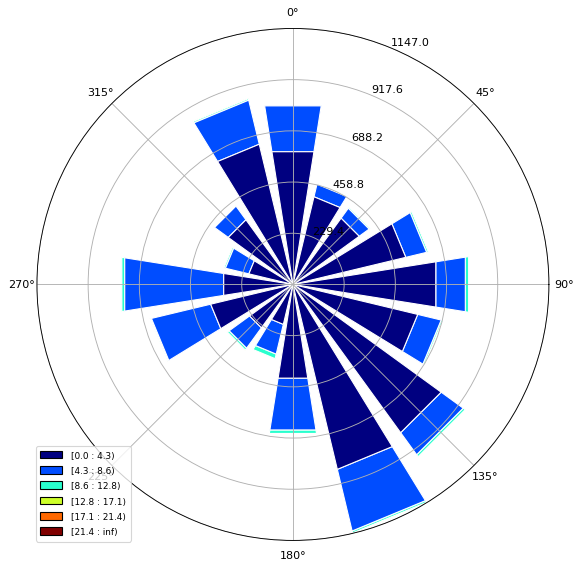

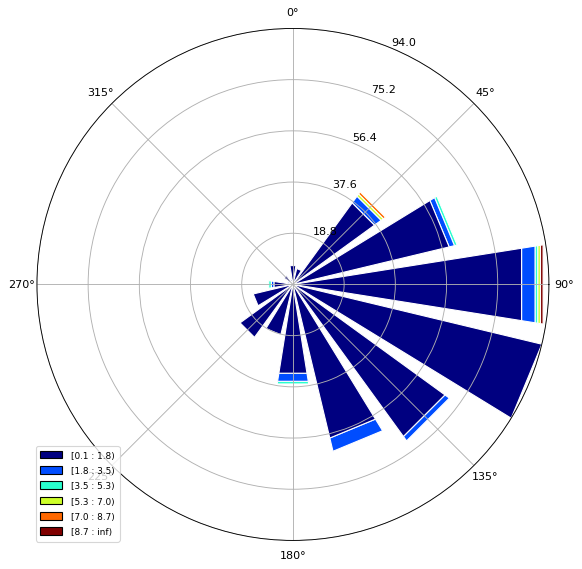

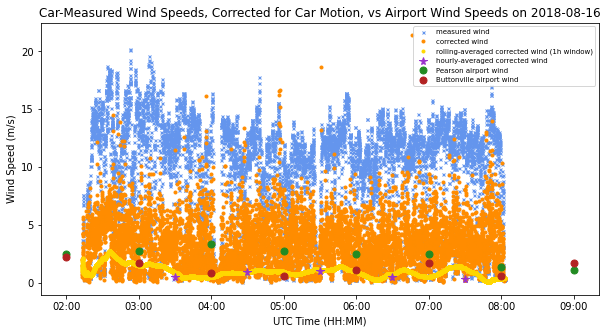

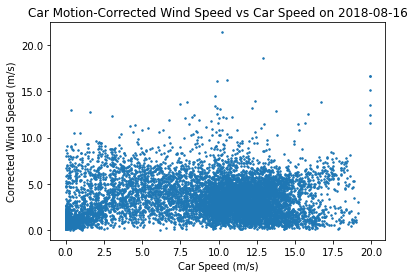

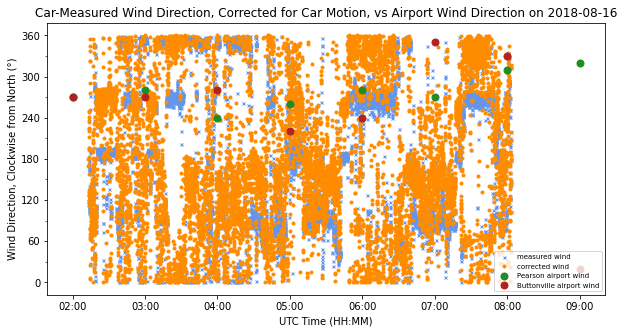

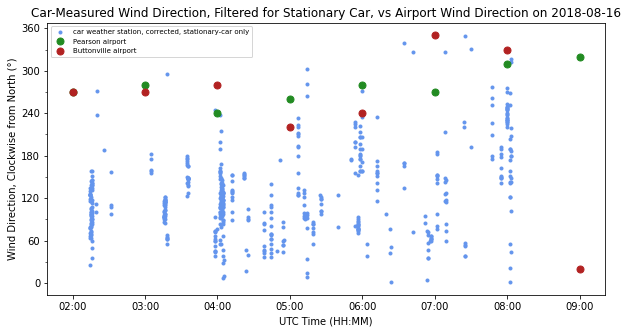

In [27]:
# for i in range(len(dates_car_uncorr)):
for i in range(1):

    day_processing = dates_car_uncorr[i]


    ## read data
    gps_time, lat, lon, wind_speed, wind_dir = read_merged_gps_wind_data(day_processing, path_sync_data)
    if (len(wind_speed) == 0) or (len(wind_dir) == 0):
        continue

    airport_time, pearson_speed, pearson_dir, buttonville_speed, buttonville_dir = read_airport_data(day_processing, path_airport_data)


    ## create directories by date for output figures
    create_output_fig_folders(day_processing, output_figures_path)

    ## calculate car speed & direction
    car_speed, car_dir, car_time = find_car_speed_and_dir(gps_time, lat, lon)

    ## car speed & dir part 2 (to be fixed) ******
    cs, cd, df_car_2 = find_car_speed_and_dir_pt2(car_speed, car_dir, car_time)

    ## wind correction
    wind_speed_corr, wind_dir_corr, wind_vector_corr_x, wind_vector_corr_y, df_wind_corr = wind_correction(cs, cd, wind_speed, wind_dir, gps_time)

    ## stationary car filter
    wind_speed_stop, wind_dir_stop, time_stop, df_wind_stop = stationary_car_filter(cs, wind_speed, wind_dir, gps_time)


    ## rolling averages of corrected winds
    wind_speed_corr_rolling_avg, wind_dir_corr_rolling_avg, time_rolling_avg = rolling_avg_winds_corr(df_wind_corr, window_size_corr)

    ## binned hourly averages of corrected winds
    wind_speed_corr_hourly_avg, wind_dir_corr_hourly_avg, time_hourly_avg, df_wind_corr_hourly_avg = binned_hourly_avg_winds_corr(df_wind_corr, gps_time, day_processing)


    ## find threshold for minimum number of points required in a window to generate a valid mean value
    threshold = find_threshold(df_wind_corr, window_size_stop)

    ## rolling averages of filtered winds
    wind_speed_stop_rolling_avg, wind_dir_stop_rolling_avg, time_stop_rolling_avg = rolling_avg_winds_stop(df_wind_stop, window_size_stop, threshold)

    ## binned hourly averages of filtered winds
    wind_speed_stop_hourly_avg, wind_dir_stop_hourly_avg, time_stop_hourly_avg, df_wind_stop_hourly_avg = binned_hourly_avg_winds_stop(df_wind_stop, time_stop, threshold, day_processing)


    ## --> plot windroses for airport data
    windrose_airports(pearson_speed, pearson_dir, buttonville_speed, buttonville_dir, day_processing,
                      output_figures_path, savefig=False)
   
    ## --> plot windrose for corrected wind data
    windrose_corrected_winds(wind_dir_corr, wind_speed_corr, day_processing,
                             output_figures_path, savefig=False)

    ## --> plot windrose for stationary car data
    windrose_stationary_car(wind_dir_stop, wind_speed_stop, day_processing,
                            output_figures_path, savefig=False)


    ## --> plot speed vs time of airport and corrected car-measured winds
    plot_corrected_speed_vs_time(gps_time, wind_speed, wind_speed_corr,
                                 time_rolling_avg, wind_speed_corr_rolling_avg, window_size_corr,
                                 time_hourly_avg, wind_speed_corr_hourly_avg,
                                 airport_time, pearson_speed, buttonville_speed, day_processing,
                                 output_figures_path, savefig=False)

    # ## --> plot speed vs time of airport and filtered car-measured winds
    # plot_filtered_speed_vs_time(time_stop, wind_speed_stop,
    #                             time_stop_rolling_avg, wind_speed_stop_rolling_avg, window_size_stop,
    #                             time_stop_hourly_avg, wind_speed_stop_hourly_avg,
    #                             airport_time, pearson_speed, buttonville_speed, day_processing,
    #                             output_figures_path, savefig=False)

    ## --> check for correlation between corrected wind speed and car speed
    plot_check_for_correlation(cs, wind_speed_corr, day_processing,
                               output_figures_path, savefig=False)


    ## --> plot direction vs time of airport and corrected car-measured winds
    plot_corrected_dir_vs_time(gps_time, wind_dir, wind_dir_corr,
                               airport_time, pearson_dir, buttonville_dir, day_processing,
                               output_figures_path, savefig=False)
    # plot_sine_corrected_dir_vs_time(gps_time, wind_dir, wind_dir_corr,
    #                                 airport_time, pearson_dir, buttonville_dir, day_processing,
    #                                 output_figures_path, savefig=False)

    ## --> plot direction vs time of airport and filtered car-measured winds
    plot_filtered_dir_vs_time(time_stop, wind_dir_stop,
                              airport_time, pearson_dir, buttonville_dir, day_processing,
                              output_figures_path, savefig=False)
    # plot_sine_filtered_dir_vs_time(time_stop, wind_dir_stop,
    #                                airport_time, pearson_dir, buttonville_dir, day_processing,
    #                                output_figures_path, savefig=False)


    print('~~~ finished processing ' + day_processing + ' ~~~\n')